In [31]:
def unpaint_dataset():
    pass

import torchvision
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

def unpaint_center(images, mask_size=0.5):
    img_size = images.shape[-1]
    mask = torch.ones_like(images)
    mask[:, int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size), int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size)] = 0
    return torch.mul(images, mask)

batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

unpaint_center_transform =  transforms.Compose(
    [transforms.ToTensor(),
     unpaint_center,
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset_cifar, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

unpainted_trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=unpaint_center_transform)

testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


sample_images = next(iter(trainloader))[0]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


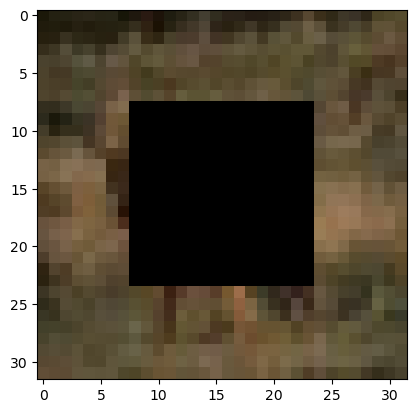

In [32]:
plt.imshow((unpainted_trainset_cifar[3][0].permute([1, 2, 0]) * 0.5 + 0.5))


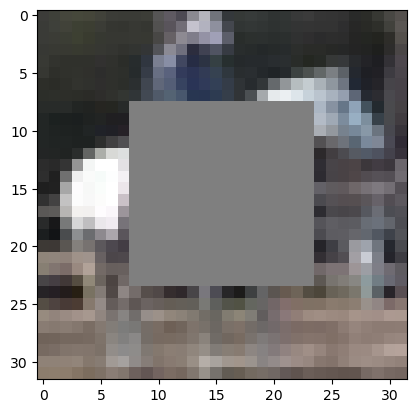

In [24]:
plt.imshow((unpaint_center(sample_images)[3].permute([1, 2, 0]) * 0.5 + 0.5))
